# **Uplift Modeling**

*by Milara*

*September 2021*

**Introduction:**
+ One of the main applications of the Machine Learning models is to improve the **Targeted Marketing**. The Targeted Marketing is used to select the customers that most likely buy a product.
+ There are different approaches for Targeted Marketing such as the **Classical modeling** (also known as Response model). This approach is focused in training a model with customers that were sent a promotion/offer. The model separates the customers that will buy from the ones that will not buy if targeted. **This approach generates higher profit than random selection targeting.** 
+ Nonetheless, the Classical modeling has a flaw. It does not separate customers that will buy even if not targeted from the ones that will only buy if targeted. In other words, the model wastes money by targeting customers that do not need it. The current solution to that issue is the Uplift modeling.
+ The **Uplift modeling** can separate customers that will buy if not targeted from the ones that will buy only if targeted, as well as avoiding customers that will not buy even if targeted. **Specifically, the model identifies the customers that are worth spending money on Targeted Marketing.** 
+ This approach can also be related to the **Churn problem**, in which the goal is to avoid losing customers. It is related because it requires to send an offer to persuade the customer that the product still provide value. Therefore, it is important to send an offer to the customers that are more likely to stay if targeted. 
+ **This notebook elaborates these two approaches for Targeted Marketing using a dataset with 13 million instances provided by Criteo (French advertising company)**.


**Objectives**
+ To show the Classical and Uplift modeling in Targeted Marketing

**Content**
+ [Problem understanding](#Problem-understanding)
+ [Data understanding](#Data-understanding)
    + [Basic EDA](#Basic-EDA)
    + [Imbalance](#Imbalance)
    + [Results of the treatments](#Results-of-the-treatments)
    + [Data preparation](#Data-preparation)
+ [Classical modeling](#Classical-Modeling)
    + [CM: Data preparation](#CM:-Data-preparation)
    + [CM: Data split](#CM:-Data-split)
    + [CM: Resampling](#CM:-Resampling)
    + [CM: Modeling](#CM:-Modeling)
    + [CM: Profit/Cost of the results](#CM:-Profit/Cost-of-the-results)
    + [CM: Profit/Cost curve](#CM:-Profit/Cost-curve)
    + [CM: Summary](#CM:-Summary)
+ [Uplift modeling](#Uplift-modeling)
    + [UM: Brief explanation](#UM:-Brief-explanation)
    + [UM: Data split](#UM:-Data-split)
    + [UM: Resampling](#UM:-Resampling)
    + [UM: Modeling](#UM:-Modeling)
    + [UM: Cumulative uplift curve](#UM:-Cumulative-uplift-curve)
    + [UM: Summary](#UM:-Summary)
+ [Conclusion](#Conclusion_)
+ [To try](#To-try)
+ [References](#References)


## **Problem understanding**

+ The data was obtained from Kaggle **"Uplift Modeling, Marketing and Campaing Data" provided by AI lab of Criteo** (French advertising company that provides online display adverstisements). **The data contains 13 million instances from a randomized control trial collected in two weeks**, where 84.6% of the users where sent the treatment **[1]**. 
+ Each instance has 12 features that were anonymized plus a treatment variable and two target variables (visits and conversion). There is another extra variable called "exposure" which indicates whether the user was effectively exposed to the treatment.
+ As mentioned before, there are two target variables (visits and conversion), **this notebook will only focus on the conversion variable**. Which can be understood as the indicator whether the user bought the product. 
+ **The goal is to generate a model that can identify users that are more likely to convert (or buy the product) and avoid the ones that are not.**
+ Before the modeling approaches, it is necessary to select the data that is useful for the models. 
+ For the sake of simplicity two models will be used in this notebook. The models are Logistic Regression and XGBoost. The first model is selected because it is normally used as the baseline. And, the second model is selected because it is known that can provide pretty good results but it is complex, it requires more resources to train, more hyperparameter fine-tunning and it is not easy interpretable. 

## **Data understanding**

In [1]:
#import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#Read the dataset
df = pd.read_csv("../input/uplift-modeling/criteo-uplift-v2.1.csv")

### **Basic EDA**

In [2]:
#Show the columns
df.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'treatment', 'conversion', 'visit', 'exposure'],
      dtype='object')

There are 12 features and 4 variables with information about the treatments and targets

In [3]:
#Check for null values
df.isnull().sum()

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

There are no null values

#### **Uni-variate analysis**

In [4]:
#Quick stats of the variables
df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01,8.500001e-01,2.916680e-03,4.699200e-02,3.063122e-02
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02,3.570713e-01,5.392748e-02,2.116217e-01,1.723164e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


The variables have 13M instances each. The stats values of the features seems to be similar. To have a better picture a boxplot is shown below.

<AxesSubplot:>

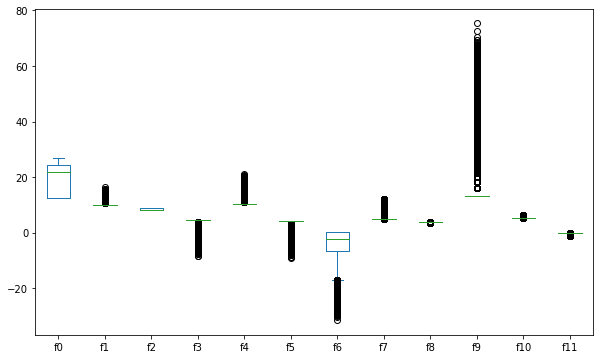

In [5]:
#Boxplots of the features
df.drop(['treatment','conversion','visit','exposure'], axis = 1).plot.box(figsize=(10,6))

The plot shows the following:
+ The range of the features is different. 
+ Only features f0 and f2 have no outliers.
+ The features that have the largest outliers are f6 and f9. 
+ The features with large outliers have them only on one side of the distribution. 
+ Some features such as f3, f4 and f5 seem to have a positive skeweness, while f0, f1, f4, f7 and f9 seem to have negative skewness.

#### **Multi-variate analysis**

<AxesSubplot:title={'center':'Pearson Correlation Matrix'}>

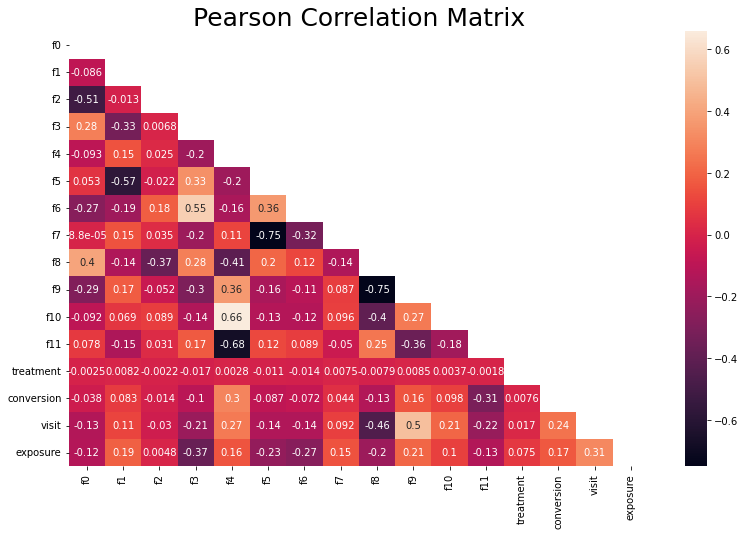

In [6]:
#Correlation Matrix
f, ax = plt.subplots(figsize=(13, 8))
plt.title('Pearson Correlation Matrix',fontsize=25)

corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

sns.heatmap(corr, annot=True, mask = mask)

There are some variables with strong correlation that should be addressed to avoid repetition of information.

**In summary:**
+ There are 12 features and 2 variables for treatment and 2 variables for target
+ There are no null values in the 13M users
+ The features have outliers, positive and negative skweness and different range of values
+ Some of the features have a strong correlation between them
    + There were no features with an absolute score correlation above 0.31 for conversion
    + There were two feautures with an absolute score correlation above 0.31 for visit
+ **It seems that feature engineering should be performed to:**
    + Reduce/remove the outliers
    + Correct the skewness of some features
    + Remove variables with strong correlation
    + Scale the values to have the same range for the sake of the models
    
+ However, the feature engineering will be reduced to only scaling of the values. A large feature engineering is out of the scope of the notebook. But it will be intersting to apply a complete feature engineering to improve the performance of the models.

### **Imbalance**

The data is highly imbalanced in four features: treatment, exposure, visits and conversion.

1    0.85
0    0.15
Name: treatment, dtype: float64


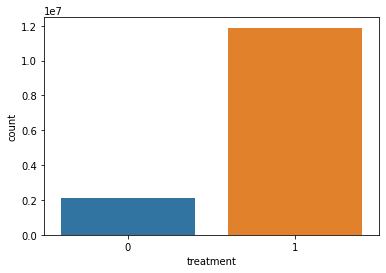

In [7]:
#Show the proportion of treatment
sns.countplot(x='treatment', data=df)
print(df['treatment'].value_counts(normalize = True))

0    0.969369
1    0.030631
Name: exposure, dtype: float64


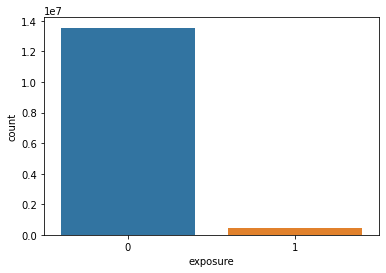

In [8]:
#Proportion of full exposure to the treatment
sns.countplot(x='exposure', data=df)
print(df['exposure'].value_counts(normalize = True))

0    0.997083
1    0.002917
Name: conversion, dtype: float64


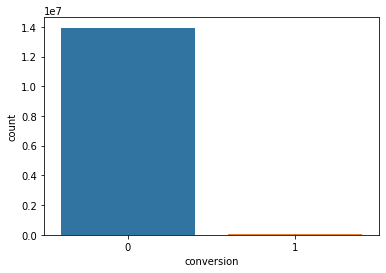

In [9]:
#Proportion of conversion
sns.countplot(x='conversion', data=df)
print(df['conversion'].value_counts(normalize = True))

0    0.953008
1    0.046992
Name: visit, dtype: float64


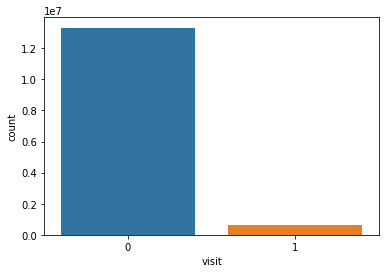

In [10]:
#Proportion of visits
sns.countplot(x='visit', data=df)
print(df['visit'].value_counts(normalize = True))

The summary of the rounded percentages is: 
+ The percetanges of **treatment** are: 85% with treatment and 15% without treatment
+ The percetanges of **exposure** are: 3% with exposure and 97% without exposure
+ The percentages of **conversion** are: 0.2% with conversion and 99% without conversion
+ The percentages of **visits** are: 5% with conversion and 95% without conversion


### **Results of the treatments**

Before moving on to the modeling stage it is highly important to determine if the randomized control trial provided a positive impact to the company. If the results generated a positive impact, then the modeling stage can be done but if the results were negative then there is no point of moving to the modeling stage. Thereby, the following analysis is intended to show the impact of the treatments on the conversions and visits. **In other words, to check if the treatment was useful or not.**

#### **Conversions**
As the goal is the conversion of the users, then how the conversion is related to the treatment and exposure?

In [11]:
#Given the treatment and exposure how is the conversion?
table_conv = df.groupby(['treatment','exposure']).agg({'conversion':['mean','sum','count']})
print(table_conv)

                   conversion                 
                         mean    sum     count
treatment exposure                            
0         0          0.001938   4063   2096937
1         0          0.001194  13680  11454443
          1          0.053784  23031    428212


From the table of above, it can be seen the following:
+ The percentage of users who were not given the treatment (nor fully exposed) and converted is 0.19%.
+ The percentage of users who were given the treatment but were not fully exposed and converted is 0.12%
+ The percentage of users who were given the treatment and fully exposed and converted is 5.38%
**It seems that it is only worth giving the full exposure instead of giving it partially.**

#### **Visits**

If the visits were the goal, how are they related to the treatment and exposure?

In [12]:
#Given the treatment and exposure, how is the visits?
table_vis = df.groupby(['treatment','exposure']).agg({'visit':['mean','sum','count']})
print(table_vis)

                       visit                  
                        mean     sum     count
treatment exposure                            
0         0         0.038201   80105   2096937
1         0         0.034861  399314  11454443
          1         0.414538  177510    428212


The table above shows following:
+ The percentage of users who were not given the treatment (nor exposed) and visited is 3.82%
+ The percentage of users who were given the treatment but not fully exposed and visited is 3.49%
+ The percentage of users who were given the full treatment and visited is 41.45%

**It can be seen similar behavior as in conversion, it seems that only giving the full treatment and avoiding sending the partial treatment yield better results.**

#### **Bonus: How do the treatment, exposure and visit impact the conversion?**

In [13]:
#Given the treatment, exposure and visits, how is the conversion?
df.groupby(['treatment','exposure','visit']).agg({'conversion':['mean','sum','count']})

conversion                 
                               mean    sum     count
treatment exposure visit                            
0         0        0       0.000000      0   2016832
                   1       0.050721   4063     80105
1         0        0       0.000000      0  11055129
                   1       0.034259  13680    399314
          1        0       0.000000      0    250702
                   1       0.129745  23031    177510

From the table of above, it can be seen the following:
+ There is no conversion if the users do not visit
+ The percentage of users who were not given the treatment (nor fully exposed) and visited and converted is 5.07%.
+ The percentage of users who were given the treatment but were not fully exposed and visited and converted is 3.42%
+ The percentage of users who were given the treatment, fully exposed and visited and converted is 12.97%

**It seems that even if the users receive the partial treatment and visit there is a drop in the percetage of conversion**

In brief, there is a negative impact of the partial treatment on the results, either on visits and coversions. Furthermore, it seems that not even making the users visit with the partial treatment can yield higher conversion.

### **Statistical tests for the treatments on results**

It is important to make a robust comparasion between the proportions of the results given the treatments. Therefore, statiscal tests are carried on.

#### *Test between control and treatment group on conversion*

In [14]:
from statsmodels.stats.proportion import proportions_ztest

proportions_ztest(count=table_conv.reset_index()[('conversion')]['sum'].loc[:1],
                  nobs=table_conv.reset_index()[('conversion')]['count'].loc[:1])[1]

6.983951422749621e-165

#### *Test between control and exposure group on conversion*

In [15]:
#Get the two groups of data
proportions_ztest(count=table_conv.reset_index()[('conversion')]['sum'].drop(1),
                  nobs=table_conv.reset_index()[('conversion')]['count'].drop(1))[1]

0.0

#### *Test between control and treatment group on visit*

In [16]:
#Get the two groups of data
proportions_ztest(count=table_vis.reset_index()[('visit')]['sum'].loc[:1],
                  nobs=table_vis.reset_index()[('visit')]['count'].loc[:1])[1]

5.150161571101964e-128

#### *Test between control and exposure group on visit*

In [17]:
#Get the two groups of data
proportions_ztest(count=table_vis.reset_index()[('visit')]['sum'].drop(1),
                  nobs=table_vis.reset_index()[('visit')]['count'].drop(1))[1]

0.0

In summary:
+ If a p-value smaller than 0.05 is considered for the statistical significance, then for all test results there is enough evidence that there is an statistical difference between the proportions.
+ This is good and bad:
    + It is good because the treatment fully exposed (*exposure*) has a positive impact on conversions and visits.
    + It is bad because the treatment not fully exposed has a negative impact on conversions and visits.
    
+ This should be addressed by the company. Nevertheless, as scope of this notebooks stated, the analysis continues only for the conversion.

+ **As well, the two treatments (treatment and exposed) can be considered different given their characteristic (partially and fully completed), thus this notebook continues only analyzing the data of the exposed users as a treatment to increase the conversion. From now on the exposure feature will be called treatment.**

### **Data preparation: data cleansing to have users only exposed and not exposed.**

Given the analysis of the previous section, it is necessary to select only the data useful for the modeling

In [18]:
#Remove the users that were treated but not exposed
users_to_remove = df[(df['treatment'] == 1 ) & (df['exposure']==0)]

#New df based on the objective of the notebook
df_ml = df.drop(users_to_remove.index).reset_index().drop(['index','treatment', 'visit'], axis = 1)

In [19]:
#Number of Treated but not exposed
len(users_to_remove)

11454443

0    2096937
1     428212
Name: exposure, dtype: int64
Normalized:
0    0.830421
1    0.169579
Name: exposure, dtype: float64


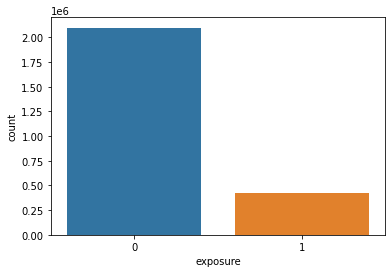

In [20]:
#Proportion of Exposure
sns.countplot(x='exposure', data=df_ml)
print(df_ml['exposure'].value_counts())
print("Normalized:")
print(df_ml['exposure'].value_counts(normalize = True))

Users converted given no exposure
0    2092874
1       4063
Name: conversion, dtype: int64
Users converted given exposure
0    405181
1     23031
Name: conversion, dtype: int64


Text(0.5, 1.0, 'Conversion given exposure')

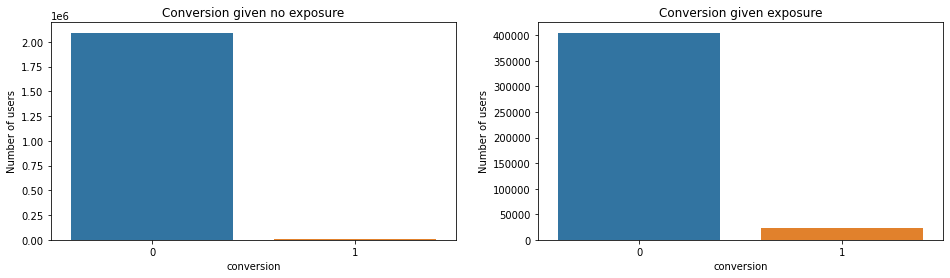

In [21]:
df_noexp = df_ml[df_ml['exposure'] == 0]
df_exp = df_ml[df_ml['exposure'] == 1]

print("Users converted given no exposure")
print(df_noexp['conversion'].value_counts())

print("Users converted given exposure")
print(df_exp['conversion'].value_counts())

#Plot both graphs
fig, ax = plt.subplots( ncols=2, figsize = (16,4))

sns.countplot(x='conversion', data=df_noexp, ax=ax[0])
ax[0].set_ylabel('Number of users')
ax[0].set_title('Conversion given no exposure')

sns.countplot(x='conversion', data=df_exp, ax=ax[1])
ax[1].set_ylabel('Number of users')
ax[1].set_title('Conversion given exposure')

*From now on Exposure is the same as Treatment.*

#### **Data scaling**

This step is performed to make all the variables have the mean of zero and standard deviation of 1. Some models from sklearn require it because their computations are very sensitive to the range of data points. Specifically the models that work with gradient descent. Both models used in this notebook use gradient descent.

In [22]:
from sklearn import preprocessing

scaled = preprocessing.scale(df_ml.drop(['conversion','exposure'], axis = 1).values)
df_sca = pd.DataFrame(data=scaled, columns = df_ml.drop(['conversion','exposure'], axis = 1).columns)
df_exposure = df_ml['exposure']
df_conversion = df_ml['conversion']

#### **Data split**

The following step is peformed to let a portion of the data be untouched, it will be used if necessary.

In [23]:
from sklearn.model_selection import train_test_split

stratify_cols = pd.concat([df_exposure, df_conversion], axis=1)

#Setting up testing and traning sets
X_train, X_test, trmnt_train , trmnt_test, y_train, y_test = train_test_split(df_sca,
                                                                             df_exposure,
                                                                             df_conversion,
                                                                             stratify = stratify_cols,
                                                                             test_size = 0.1,
                                                                             random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (2272634, 12)
Test shape: (252515, 12)


<a id='section'></a>

## **Classical Modeling**

In this section the profile of the users is used to create a model that can identify new users with high probabilty of conversion if targeted. This is called the classical modeling because it uses data labeled with the ground truth. The benefit of this type of modeling is that it helps you to avoid the users who will not convert if targeted. **Thus, the data to use is only the group of users who were targeted ("exposed").** This approach is also called Response model and Traditional Propensity model **[2,10]**.

### **CM: Data preparation**

The instances that were given the treatment are selected.

In [24]:
#Selection of instances only exposed
y_traincml = y_train[trmnt_train==1]
X_traincml = X_train[trmnt_train==1]

Even that a vast number of instaces were removed the imbalancing remains. Note that from having 13M instances only around 400k have the characteristics needed for this stage.

0    364663
1     20728
Name: conversion, dtype: int64
Normalized:
0    0.946216
1    0.053784
Name: conversion, dtype: float64


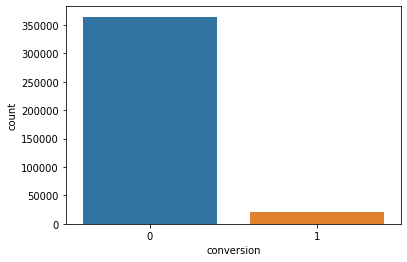

In [25]:
#Imbalanced in the conversion variable
sns.countplot(x='conversion', data=y_traincml.to_frame())
print(y_traincml.value_counts())
print("Normalized:")
print(y_traincml.value_counts(normalize = True))

### **CM: Data split**

The data is divided in train and validation tests.

In [26]:
#Setting up testing and training sets
X_train_cml, X_val_cml, y_train_cml, y_val_cml = train_test_split(X_traincml,y_traincml, test_size=0.3, random_state=42)

print('Train instances: {}, None_Conversion: {} and Conversion: {}'.format(len(y_train_cml),
                                                                         y_train_cml.value_counts()[0],
                                                                         y_train_cml.value_counts()[1]))

print('Val instances: {}, None_Conversion: {} and Conversion: {}'.format( len(y_val_cml), 
                                                                         y_val_cml.value_counts()[0],
                                                                         y_val_cml.value_counts()[1]))

Train instances: 269773, None_Conversion: 255282 and Conversion: 14491
Val instances: 115618, None_Conversion: 109381 and Conversion: 6237


### **CM: Resampling**

The proportion of the target variable is imbalanced, thus the over-sampling technique SMOTE is used to increase the number of conversion users to have half of the size of the non_conversion. Note that other ratio could be used.

In [27]:
#SMOTE
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42 )
X_train_sm, y_train_sm = sm.fit_resample(X_train_cml, y_train_cml)

print(y_train_sm.value_counts())

0    255282
1    255282
Name: conversion, dtype: int64


### **CM: Modeling**

Three models are used, the first model is random (to have a baseline), the second is Logistic Regression and the third is XGBoost. As the target variable is imbalanced all the models are evaluated on precision and recall to focus on False Positives and False Negatives. An important note is that all of the the models are trained on balanced data to learn how to generalize and then evaluated on imbalanced  data.

In [28]:
from sklearn.dummy import DummyClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.linear_model import LogisticRegression

In [29]:
#DummyClassifiert to predict only target 0
dummy = DummyClassifier(strategy='uniform', random_state=42).fit(X_train_sm, y_train_sm)
dummy_pred = dummy.predict(X_val_cml.values)

print("Precision: ", precision_score(y_val_cml, dummy_pred))
print("Recall: ", recall_score(y_val_cml, dummy_pred))

Precision:  0.054207510699986194
Recall:  0.5036075036075036


In [30]:
#Logistic regression model
logreg_sm = LogisticRegression().fit(X_train_sm.values, y_train_sm.values)
logreg_sm_pred = logreg_sm.predict(X_val_cml.values)

print("Precision: ", precision_score(y_val_cml, logreg_sm_pred))
print("Recall: ", recall_score(y_val_cml, logreg_sm_pred))

Precision:  0.19507329343394916
Recall:  0.7211800545133878


In [31]:
#Extreme Gradient Boosting
xgb_sm = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'aucpr',  use_label_encoder = False).fit(X_train_sm.values,
                                                                                      y_train_sm.values)
xgb_sm_pred = xgb_sm.predict(X_val_cml.values)

print("Precision: ", precision_score(y_val_cml, xgb_sm_pred))
print("Recall: ", recall_score(y_val_cml, xgb_sm_pred))

Precision:  0.28466776723070575
Recall:  0.4423601090267757


Surprisingly, the XGBoost did not provide the best results. Instead, the Logistic Regression model provided the best results. 

### **CM: Profit/Cost of the results**

**Rather than only using technical metrics to know if the models are doing it well or not such as Precision and Recall, another method that takes into account the profits generated by the models is used. Similar to the method proposed by Provost. [3]** 

The model has four possible outcomes: True Positive (correctly targeted), False Positive (incorrectly targeted), True Negative (correctly not targeted) and False Negative (incorrectly not targeted). Based on the business it is necessary to define a benefit and cost for each one of them. Thus, lets assume the following: the cost of sending the campaing (or promotion) per user is 1 USD and if the user converts then the benefit is 50 USD. Another assumption, is that if the user is not targeted then the benefit is zero (which in real scenarios this may not happen but this is outside of the scope of this notebook).

+ True Positives (TP): the benefit of targeting and conversion is 50-1 = 49 USD
+ True Negatives (TN): the benefit of not targeting is 0 
+ False Positives (FP): the cost of targeting when there is no conversion is 1 USD
+ False Negatives (FN): the cost of not targeting to a user who would have been converted is 49 USD

Therefore the profit equation is the following:
+ $ profit = TP*49 - FP*1 - FN*49$

**Note: the value of each outcome of the model can be changed based on the business information.** 

In [32]:
values = {'tp':49, 'fp':1, 'fn':49}

def value_eq(values, conf_matrix): 
    """
    Function that computes the value generated by the model
    
    Parameters:
    -----------
    values: dict with the values of the outcomes
    conf_matrix: confusion matrix of the models
    """
    tp = conf_matrix[1,1]
    fp = conf_matrix[0,1]
    fn = conf_matrix[1,0]
    
    return tp*values['tp'] - fp*values['fp'] - fn*values['fn']

Computation of the profits

In [33]:
#Confusion Matrix of Random Pred
cm_rand_sm = confusion_matrix(y_val_cml, dummy_pred)

#Confusion Matrix of Logistic Regression
cm_logreg_sm = confusion_matrix(y_val_cml, logreg_sm_pred)

#Confusion Matrix of XGB
cm_xgb_sm = confusion_matrix(y_val_cml, xgb_sm_pred)

#Print the benefit from both models
print(f'The profit in USD with the Random model is $ {value_eq(values,cm_rand_sm):,.2f}')
print(f'The profit in USD with the Logistic Regression model is $ {value_eq(values,cm_logreg_sm):,.2f}')
print(f'The profit in USD with XGBoost model is $ {value_eq(values,cm_xgb_sm):,.2f}')

The profit in USD with the Random model is $ -52,598.00
The profit in USD with the Logistic Regression model is $ 116,631.00
The profit in USD with XGBoost model is $ -42,164.00


As expected the model with the highest profit is the Logisit Regression because it has lesser False Postive and False Negative errors than the other two models.

### **CM: Profit/Cost curve**

Another technique to measure the performance of the models is using a profit/cost curve. With this technique the users are sorted by the probability of conversion provided the models and then they are compared to the ground truth (whether they bought or not). Consecutively, the cummulative profit is calculated. This technique is very helpful when the desire is to get the highest profit but the budget for targeting is not enough to target all of the users. In this sense, it is possible to target the k users with highest probability of conversion. **[3]**

In [34]:
def outcome_value(y_pred,y_test,values):
    """
    Returns the value of the outcome
    
    Parameters:
    -----------
    y_pred: classes estimated by the classifier
    y_test: actual classes
    value: value of the outcome
    """
    if y_pred == 1 and y_test == 1:
        return values['tp']
    if y_pred == 1 and y_test==0:
        return -values['fp']
    elif y_pred== 0 and y_test==1:
        return -values['fn']
    else:
        return 0
    
def compute_value_df(y_proba,y_test,values, best_thres= 0.5):
    """
    Generates a df with the cummulative cost of the errors
    
    Parameters:
    ------------
    y_proba: array with the probabilities of X_test given by an estimator
    y_test: array with the actual values of y
    best_thres: int best threshold to define a binary outcome
    values: dict with the value of the outcomes
    """
    #Build the df for the cost curve
    df_value_curve = pd.DataFrame({'y_proba':y_proba, 
                                         'y_pred': np.where(y_proba > best_thres,1,0),
                                         'y_test':y_test})

    #Sort df by probability
    df_value_curve = df_value_curve.sort_values(by='y_proba'
                                                            , ascending = False).reset_index().drop('index', axis =1)

    #Compute the value of each outcome
    df_value_curve['value'] = df_value_curve.apply(lambda x: outcome_value(x.y_pred, x.y_test,values), axis=1)

    #Compute the cummulative sum of the outcomes
    df_value_curve['cum_value'] = df_value_curve['value'].cumsum(axis=0)
    
    return df_value_curve

Calculation of the cummulative profit 

In [35]:
#random model 
dummy_proba = dummy.predict_proba(X_val_cml.values)[:,1]
df_dummy_val_curve = compute_value_df(dummy_proba,y_val_cml,values)

#Get the probabilities for each instance based on the estimator
logreg_y_proba = logreg_sm.predict_proba(X_val_cml.values)[:,1]
df_logreg_val_curve = compute_value_df(logreg_y_proba,y_val_cml,values)

#Get the probabilities for each instance based on the estimator
xgb_y_proba = xgb_sm.predict_proba(X_val_cml.values)[:,1]
df_xgboost_val_curve = compute_value_df(xgb_y_proba,y_val_cml,values)

Plot the profit/cost curves for all the models

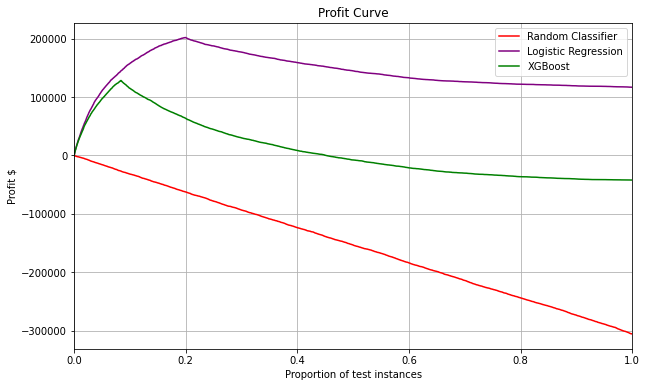

In [36]:
_, axes = plt.subplots(figsize=(10, 6))

instances=np.arange(0, 1, (1/len(y_val_cml)))

axes.set_title("Profit Curve")
axes.set_xlabel("Proportion of test instances")
axes.set_ylabel("Profit $")
axes.grid(b=True)

axes.plot(instances, df_dummy_val_curve['cum_value'].values, '-', color="red",label="Random Classifier")
axes.plot(instances, df_logreg_val_curve['cum_value'].values, '-', color="purple",label="Logistic Regression")
axes.plot(instances, df_xgboost_val_curve['cum_value'].values, '-', color="green",label="XGBoost")

axes.legend(loc="best")
axes.set_xlim(0,1)
#axes.set_ylim(0,1)
plt.show()

The graph above shows the following:
+ The x axis is the proportion of data used by the company to send the targeted marketing
+ The y axis is the benefit obtained for targeting the users
+ **The curves show the cummulative profit of users that were sorted by their probability of being converted. In other words, the first users targeted are the ones with highest probability of being converted**
+ In order to know the benefit, a thershold for the probability is defined to decide if the user is targeted or not. In this case a threshold of 0.5 was used to determine to target or not, yet this value can be tunned

Regarding the models:
+ **The Logistic Regression model has a maximum of profit close to 200,000 USD**
+ The XGBoost model has a maximum around 100,000 USD
+ The random model never generates a benefit

As well the graph implies the following:
+ If 0.2 proportion of users were used to send the marketing campaing, then the best model to use would be Logistic Regression.
+ **However, if all the users were used to send the marketing campaing, based on the model results, then the best model to use would be Logisict Regression as well, because after using the 0.8 proportion of users the benefit would not be decreasing dramatically such as for the Random and XGBoost models.**
+ The curves decrease when they fail to detect correctly the users that will convert.
+ The ideal curve would be the one that it gets to the maximum and after that it does not decreases, because it would mean that it correctly found all the users to be converted and would not be losing money by not targeting users that could be converted if targeted.

### **CM: Summary**

+ This section elaborates on the classical modeling approach to identify users that most likely will convert if a targeted campaing is sent. The procedure followed was to scale and resample the data, generate three models and finally compare the models using a profit/cost technique. Other techniques to improve the model results such as outlier removal, feature selection and hyperparameter tunning were not used due to scope of the analysis. The same case for the evaluation with cross-validation. 
+ **However, this approach has a pitfall. How do we know if a user who received the campaing could have been converted if the user hadn't received it? If this is possible, then the model is causing the company to lose money by targeting users that would convert without being targeted. To address this pitfall the Uplift modeling should be used instead.**

## **Uplift modeling**

This technique combines Machine Learning with causal inference to determine the impact of the treatment (or an action) on the target variable. In other words, it helps to know if its necessary to treat the user or not. To be clearer, the method is explained with the following table **[4]**:


|                    | Not buy if not treated | Buy if not treated |
|--------------------|------------------------|--------------------|
| **Buy if treated**     | Persuadables           | Sure things        |
|**Not buy if treated** | Lost Causes            | Sleeping dogs      |

The possible outcomes are four:
+ The customers that will buy only if treated: persuadables
+ The customers that will buy no matter if treated or not treated: sure things
+ The customers that will not buy no matter if treated or not treated: lost causes
+ The customers that will buy only if not treated: sleeping dogs

The classical modeling only avoids the lost causes while the uplift modeling avoids the sure things, lost causes and sleeping dogs. **Specifically, uplift modeling focuses on the persuadables customers.**


### **UM: Brief explanation**

*The key ideas to take are **[5]** :*
+ The main concept behind the model is **causal inference** in which the aim is to calculate the difference between the response of a customer given that she received the treatment and response given that she did not receive the treatment . 
+ Unfortunately, to measure this is impossible because a customer can not receive and not receive the treatment, there is no ground truth. Therefore, an estimation is calculated.
+ The estimation is nothing more that the probability of a customer responding given the treatment minus the probability of the customer responding given no treatment. And the probabilities are provided by the models.
+ **This difference is the estimation of the Uplift, also known as Conditional Average Treatment.**
+ The largest the uplift the better to treat the customer.
+ The estimation has the assumption that the treatment is applied randomly, thus independent of the potential results. 

*And regarding the modeling:*
+ There are different types of models such as the Direct and Meta-Learners.
    + The Direct models aim to predict the uplift, such as Uplift trees.
    + The Meta-Learners are a combination of models and data processing techniques to estimate the uplift, such as Class Transformation and Two models.
+ Each of the model has their own pros, cons and assumptions. For this notebook the models used are:
    + Single model and Two models.
+ They are selected because they are easily interpretable. 
+ **The single model:**
    + A usual model such as Logistic Regression or XGBoost is trained with train data and the feature indicating if the treatment was received or not. The results are computed by estimating the probability of response twice. The first time by using the test set and the treatment indicator as 1, and the second time by using the treatment indicator as 0. Lastly, the two probabilities given by the model are substracted to get the uplift **[6]**.
+ **The Two models:**
    +  This is similar as the single but it trains two independent models, the first model is trained with the treated customers and the second model is trained with the non-treated customers. In the end, the test set is used in both models and the results are substracted to get the uplift **[7]**.

### **UM: Data split**

The data is split in two train and test, but it also is necessary to split the treatment variable. 

In [37]:
stratify_cols = pd.concat([trmnt_train, y_train], axis=1)

#Setting up testing and traning sets
X_trainup, X_valup, trmnt_trainup , trmnt_valup , y_trainup , y_valup = train_test_split(X_train,
                                                                                         trmnt_train,
                                                                                         y_train,
                                                                                         stratify = stratify_cols,
                                                                                         test_size = 0.3,
                                                                                         random_state=42)

print(f"Train shape: {X_trainup.shape}")
print(f"Validation shape: {X_valup.shape}")

Train shape: (1590843, 12)
Validation shape: (681791, 12)


### **UM: Resampling**

The amount of data is huge, over 1 million of instances, more than the used for the Classical modeling because here the model is using the targeted and not targeted users. Nevertheless, the imbalance is notorious. Therefore, the mayority class is sub-sampled to have the same number of instances as the minority class. Recall that the models work better if they are trained with balanced classes. Notwithstanding, in the case of uplift the models the variable that is balanced is the treatment instead of the target. Because some of the models work with the assumption that the control and treatment groups have the same size. But it would be interersting to try also balancing the target variable.

<AxesSubplot:xlabel='exposure', ylabel='count'>

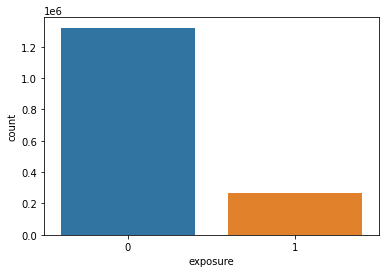

In [38]:
#Imbalanced in the treatment variableo
sns.countplot(x='exposure', data=trmnt_trainup.to_frame())

This could be also be done with over-sampling the minority class, but as the instances are over a million, it requires more comptuer resources and time to make the computations. 

In [39]:
#Subsampling the mayority class (could be done with over-sampling the minority class but it consumes too much resources)
tmp = X_trainup.copy()
tmp.insert(len(tmp.columns)-1, 'conversion', y_trainup.values)
tmp.insert(len(tmp.columns)-1, 'exposure', trmnt_trainup.values)

#separte df based on the treatment
tmp1 = tmp[tmp['exposure']==1]
tmp2 = tmp[tmp['exposure']==0]

#Subsampling
tmp2 = tmp2.sample(n=len(tmp1))
tmp3 = pd.concat([tmp1,tmp2], axis=0)

#Updating the variables
X_trainup_sub = tmp3.drop(['exposure','conversion'], axis = 1)
trmnt_trainup_sub = tmp3['exposure']
y_trainup_sub = tmp3['conversion']

Plot the balance treatment feature

<AxesSubplot:xlabel='exposure', ylabel='count'>

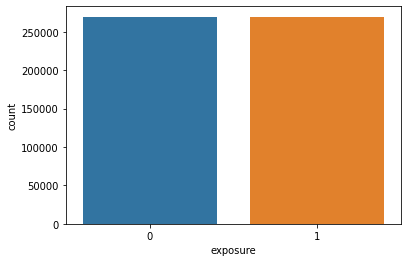

In [40]:
#Checking the umbalance
sns.countplot(x='exposure', data=trmnt_trainup_sub.to_frame())

### **UM: Modeling**

In the following lines of code two types of uplift models are used, the single model and two models. These models are from the scikit package for uplift.

In [41]:
!pip install scikit-uplift

In [42]:
from sklift.models import SoloModel, TwoModels

estimator = LogisticRegression()

#Single Model
sm = SoloModel(estimator)
sm = sm.fit(X_trainup_sub, y_trainup_sub, trmnt_trainup_sub)
uplift_sm = sm.predict(X_valup)

#Two Independent models
tm = TwoModels(estimator_trmnt= LogisticRegression(), estimator_ctrl= LogisticRegression(), method='vanilla')
tm = tm.fit(X_trainup_sub, y_trainup_sub, trmnt_trainup_sub)
uplift_tm = tm.predict(X_valup)

### **UM: Cumulative uplift curve**
One of the principal methods to assess the performance of the uplift models is using the cumulative gain plot. The plot is similar to the profit/cost curve in the sense that the instances are sorted based on the results of the models. But they are different in the vertical axis, one shows the cumulative profit and the other the cumulative uplift. The following functions are used to compute the cumulative uplfit based on **[8,9]**. 

In [43]:
def get_tc(treatment,target):
    """
    Function that returns helps to select the users that were in the control group and have a positive response
    
    Parameters:
    ------------
    treatment = treatment
    target = the response 
    """    
    if not target:
        return 0
    elif not treatment:
        return 1
    else:
        return 0
    
def compute_gain(df_x, uplift, treatment, y, rnd = False):
    """
    Function that computes the cumulative gains in a dataframe
    
    Parameters:
    ------------
    uplift = arr with the predicted uplifts by the models
    trtment = arr with the treatment indicator (test)
    y = arr target variable (test)
    rnd = bool indicating if random selection
    """
    e = 0.0000000000001 # to avoid divisions by zero
    base = pd.DataFrame({'uplift':uplift, 'treatment':treatment.values, 'target': y.values})

    df = pd.concat([df_x,base], axis = 1)
    
    #sort based on the flag
    if rnd:
        df = df.sample(frac=1).reset_index().drop('index', axis =1)
    else:
        df = df.sort_values(by='uplift', ascending = False).reset_index().drop('index', axis =1)
    
    #Compute the cumulative treatment size
    df['cum_trs'] = df['treatment'].cumsum(axis=0)

    #Compute the cumulative control size
    df['cum_crs'] = (df.index+1) - df['treatment'].cumsum(axis=0)
    
    #Compute target given treatment
    df['ttr'] = df['treatment'] * df['target']
    
    #Compute target given control
    df['tcr'] = df.apply(lambda x: get_tc(x.treatment, x.target), axis=1)
    
    #Compute cumulative target given treatment
    df['cum_ttr'] = df['ttr'].cumsum(axis=0)
    
    #Compute cumulative target given control
    df['cum_tcr'] = df['tcr'].cumsum(axis=0)
    
    #Compute cumulative gain from one to uplift [descent]
    df['cum_gain'] = (df['cum_ttr']/(df['cum_trs']+e)) - (df['cum_tcr']/(df['cum_crs']+e))
    
    #Compute cumulative gain from zero to uplift [ascending]
    df['cum_gain2'] = df['cum_gain']*(df['cum_trs']+df['cum_crs']+e)/ len(df)
    
    return df   
    

The results of the modeling in the test set are used to compute the cumulative uplift 

In [44]:
df_x_valup = X_valup.reset_index().drop('index',axis=1)

#Compute gain for the three models
sm_gain = compute_gain(df_x_valup, uplift_sm,trmnt_valup, y_valup)
tm_gain = compute_gain(df_x_valup, uplift_tm,trmnt_valup, y_valup)
rnd_gain = compute_gain(df_x_valup, uplift_tm,trmnt_valup, y_valup, True)

In [45]:
#Store the results for the modeling

save_df = pd.DataFrame({'gain_twomodel':tm_gain['cum_gain2'] , 'gain_random':rnd_gain['cum_gain2']})

#save_df.to_csv("C:/Users/Milara/Desktop/New Projects/uplift_results.csv", encoding="ISO-8859-1", index= False)

The results are plotted

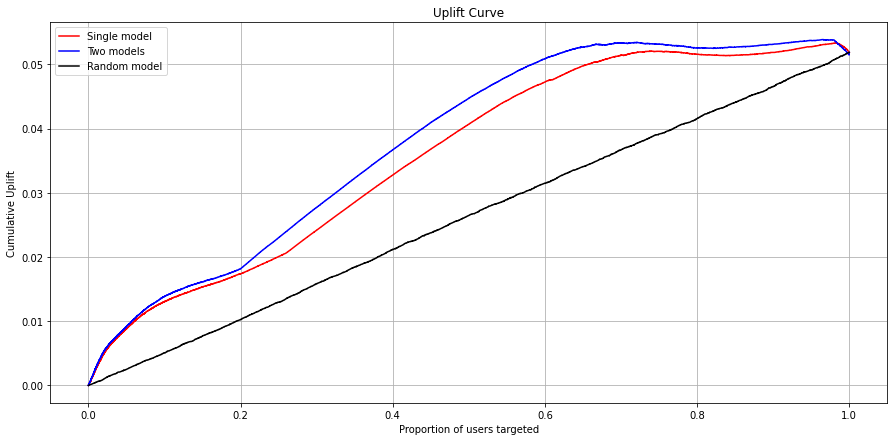

In [46]:
#Plot the results
_, axes = plt.subplots(figsize=(15, 7))

instances=np.arange(0, 1, (1/len(y_valup)))

axes.set_title("Uplift Curve")
axes.set_xlabel("Proportion of users targeted")
axes.set_ylabel("Cumulative Uplift")
axes.grid(b=True)
axes.plot(instances, sm_gain['cum_gain2'].values, '-', color="r",label="Single model")
axes.plot(instances, tm_gain['cum_gain2'].values, '-', color="b",label="Two models")
axes.plot(instances, rnd_gain['cum_gain2'].values, '-', color="k",label="Random model")
axes.legend(loc="best")
#axes.set_xlim(0,0.5)
#axes.set_ylim(0,0.5)
plt.show()

The graph above shows the following:
+ The x axis is the proportion of data used by the company to send the targeted marketing.
+ The y axis is the uplift obtained for targeting the users.
+ **The curves show the cummulative profit of users that were sorted by their probability of being converted. In other words, the first users targeted are the ones with highest uplift.**

Regarding the models:
+ All models get eventually to the 5% of uplift after targeting all the users.
+ **The objective of the curves is to show that if only 50% of the users are targeted, then it would be wise to use the results of the Two models because it reaches almost 5% of the uplift, while the random selection would only reach around half of the maximum uplift.** The proportion of users can be changed based on the needs of the company.
+ The results of the single and two models have similar behaviour, but the two models still provide better results from 0.2 to 0.8 proportion of users.

As well the graph implies the following:
+ The first part of the curve are the users are the persudables, followed by the sure things and lost causes, and finally the sleeping dogs. 
+ The ideal curve is the one that with the first amount of instances reaches the maximum uplift, then the curve keeps the same level of uplift due to the sure things and lost causes, and finally the curve will decrease at some point due to the sleeping dogs.

It seems the curve has 3 divisions, during the first uplift, then in the middle and finally at the end when the uplift decreases. Thus, just for fun three profiles are obtained from these 3 parts of the plot. The following plot shows the median values from each one of the profiles

In [47]:
cut1 = int(len(tm_gain)*0.2)
cut2 = int(len(tm_gain)*0.6)

tm_gain_variables = tm_gain[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']]

profile_1 = tm_gain_variables.iloc[:cut1]
profile_2 = tm_gain_variables.iloc[cut1+1:cut2]
profile_3 = tm_gain_variables.iloc[cut2+1:]

In [48]:
import plotly.graph_objects as go

categories = profile_1.columns

#Plot 
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
        r= profile_1.median().to_list(),
        theta=categories,
        fill='toself',
        name='Profile_1\'s area'
))

fig.add_trace(go.Scatterpolar(
        r= profile_2.median().to_list(),
        theta=categories,
        fill='toself',
        name='Profile_2\'s area'
))

fig.add_trace(go.Scatterpolar(
        r= profile_3.median().to_list(),
        theta=categories,
        fill='toself',
        name='Profile_3\'s area'
))

fig.show()

In the image above shows the following:
 + The variables that are most different from the first profile to the others are *f8* and *f9* .
 + The variable that is most different from the second profile to the others is *f0*.
 + The variable that is most different from the third profile to the others is *f2*.

### **UM: Summary**

+ This section elaborates on the uplift modeling approach to identify persuadables users. The procedure followed was to scale and resample the data, generate 3 models and finally compare the models using a Cumulative uplift curve. Other techniques to improve the model results such as outlier removal, feature selection and hyperparameter tunning were not used due to scope of the analysis. The same case for the evaluation with cross-validation. 
+ The results show that by using the uplift modeling the gains on the uplift can be doubled for a certain amount of targeted users.
+ **A disadvatage of this approach is that the ground truth is not know because a customer can not receive and not receive a treatment (promotion). Thus, the uplift model has no error to be compared such as Classical modeling, meaning that the outputs generated by both approached cannot be compared with the same metrics. [11]**
+ Nevertheless, there are some research articles proposing different metrics to assess both models in terms of profit and costs. But this is not in the scope of this notebook. 


## **Conclusion_**

This notebook elaborated two approaches for Targeted Marketing. It started by selecting the information that is worth used by the models. Then, the first approach called **"Classical modeling"** was presented, which takes only the targeted users (from a randomize experiment for targeted marketing) to train the models. Then, the models were used to determine the users that if targeted will convert. Also, the technique "Profit/Cost curve" was used to compare the performance of the models in terms of money. In the following part of the notebook the **"Uplift modeling"** was shown. The models were trained with the results of a randomized experiment for targeted marketing. Then, the results were used to determine the users that if targeted  will provide the highest uplift. Finally, a the Cumulative Uplift curve was used to compare the results of the models.

The downside of the Classical modeling approach it only avoids the lost causes. On the other side, the Uplift modeling is trained to identify firstly the persuadable users. **Both approaches will provide benefit to the companies that used them instead of a randomized targeting, the only difference is that the Uplift modeling will reduce the cost of targeting users that do not need it and the losses for customers that will buy if not targeted.**

## **To try**
This notenbook provided an overview of the models and how to use them in an easly manner. Yet there still plenty of room for improvement such as:
+ More Feature Engineering (outlier and correlation removal, correction of the skeness of the features distributions)
+ Hyperparameter tunning
+ Validation with Cross-validation 
+ Check of learning and over-fitting curves
+ Using more Machine Learning models
+ Try metrics from literature to compare the performance between the Classical and Uplift modeling with the hold-out data generated at the beginning of the notebook
+ Analyse the most important features
+ Use other packages causalML (from Uber) and pylift.

## **References**

+ [1] The Criteo AI Lab, "Uplift Modeling , Marketing Campaign Data", https://www.kaggle.com/arashnic/uplift-modeling
+ [2] Scikit-uplift,"Uplift vs other models", https://www.uplift-modeling.com/en/latest/user_guide/introduction/comparison.html
+ [3] Provost,F and Fawcett, Tom. (2013). Data science-what you need to know about analytic-thinking and decision-making. USA: O'RELLY.
+ [4] Kane, K., Lo, V. S., und Zheng. J., 2014. Mining for the Truly Responsive Customers and Prospects Using True-Lift Modeling: Comparison of New and Existing Methods. Journal of Marketing Analytics, 82(4), pp. 218-238.
+ [5] Scikit-uplift, "Causal Inference: Basics", https://www.uplift-modeling.com/en/latest/user_guide/introduction/cate.html
+ [6] Scikit-uplift, "Single model approaches", https://www.uplift-modeling.com/en/latest/user_guide/models/solo_model.html
+ [7] Scikit-uplift, "Two models approaches",https://www.uplift-modeling.com/en/latest/user_guide/models/two_models.html
+ [8] AMBIATA,"How uplift modeling works", https://ambiata.com/blog/2020-07-07-uplift-modeling/
+ [9] Susan Currie Sivek Ph.D, "Beyond Churn: An Introduction to Uplift Modeling", https://towardsdatascience.com/beyond-churn-an-introduction-to-uplift-modeling-d1d9af7be
+ [10] Shelbey Temple, "Uplift Modeling: A Quick Introduction", https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
+ [11] The Data Lab,"Understanding Customer Behaviour Using Uplift Modelling", https://www.thedatalab.com/tech-blog/understanding-customer-behaviour-using-uplift-modelling/
+ [12] Floris Devriendt, Jeroen Berrevoets, Wouter Verbeke, Why you should stop predicting customer churn and start using uplift models, Information Sciences (2019), doi: https://doi.org/10.1016/j.ins.2019.12.075